# Intersubject correlation
This notebook provides interactive examples of intersubject correlation (ISC) analysis using BrainIAK. When participants receive the same stimulus (e.g. an audiovisual movie or spoken story), part of their brain activity is driven by the stimulus and is thus shared across individuals. ISC analysis is a family of simple methods for measuring this shared, stimulus-driven response across subjects ([Hasson et al., 2004](https://doi.org/10.1126/science.1089506); [Nastase et al., 2019](https://doi.org/10.1093/scan/nsz037)). In the following, we compute ISC on an example story-listening dataset, then briefly touch on some extensions of ISC analysis. This notebook accompanies the manuscript "BrainIAK: The Brain Imaging Analysis Kit" by Kumar and colleagues (2020).

#### Outline
* Example fMRI dataset and atlas
* Computing ISC on the example data
* ISC reveals temporal receptive windows
* Intersubject pattern correlation
* Intersubject functional network estimation

In [181]:
# Import necessary python modules
from glob import glob
import numpy as np
import nibabel as nib
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt 
from brainiak.isc import isc, isfc

### Example fMRI data and atlas
To explore ISC analysis, we use an fMRI dataset collected while participants listened to two versions of a audio story called "It's Not the Fall that Gets You" by Andy Christie. Participants either listened to the original version of the story (referred to as the *intact* condition) or a temporally scrambled version of the story (referred to as the *shortscram* condition). These data are available as part of the [Narratives](https://github.com/snastase/narratives) collection ([Nastase et al., 2019](https://openneuro.org/datasets/ds002345)) and were recently published in work by Chien and Honey ([2020](https://doi.org/10.1016/j.neuron.2020.02.013)). Here, we download a pre-packaged subset of the data from Zenodo. These data have been preprocessed using fMRIPrep and "cleaned" using confound regression in AFNI. To reduce computational demands, we compute parcel-wise ISCs using a cortical parcellation containing 400 parcels from Schaefer and colleages ([2018](https://doi.org/10.1093/cercor/bhx179)).

In [23]:
# Download example fMRI data and atlas from Zenodo
intact_fns = sorted(glob('data/sub-*_task-notthefallintact_*bold.nii.gz'))
atlas_fn = 'data/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_3mm.nii.gz'

# Load in the Schaefer 400-parcel atlas
atlas_nii = nib.load(atlas_fn)
atlas_img = atlas_nii.get_fdata()

# Load in intact functional data and compute parcel means
intact_parcels = []
for intact_fn in intact_fns:
    intact_data = nib.load(intact_fn).get_fdata()
    intact_means = [np.mean(intact_data[atlas == parcel, :], axis=0)
                    for parcel in np.unique(atlas)[1:]]
    intact_parcels.append(np.column_stack(intact_means))
intact_parcels = np.dstack(intact_parcels)

### Compute intersubject correlation
Next we compute leave-one-out ISCs on data from the *intact* condition for each parcel using BrainIAK's `isc` function. We average ISC values across subjects for visualization. This reveals high ISCs in superior temporal auditory cortex, as well as strong ISCs extending into higher level cortical areas, such as the precuneus and other nodes of the default-mode network. Here, we simply want to visualize ISC rather than perform a statistical test, so we threshold the maps at ISC > .10. BrainIAK provides several nonparametric statistical tests (e.g. `bootstrap_isc`, `phaseshift_isc`); for a more thorough statistical treatment, we refer readers to a series of papers by Chen and colleagues ([2016](https://doi.org/10.1016/j.neuroimage.2016.05.023), [2017](https://doi.org/10.1016/j.neuroimage.2016.08.029), [2020](https://doi.org/10.1016/j.neuroimage.2019.116474)).

In [182]:
# Compute parcel-wise ISC using the leave-one-out approach
intact_iscs = isc(intact_parcels, pairwise=False,
                  summary_statistic='mean')

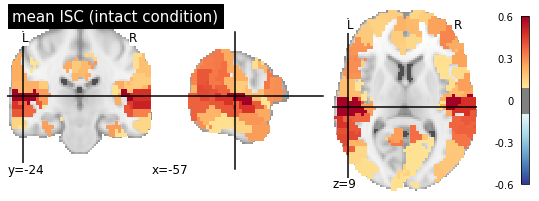

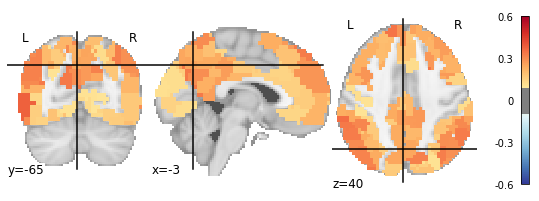

In [186]:
# Project intact parcel-wise ISC values onto brain
intact_img = np.zeros(atlas.shape)
for i, parcel in enumerate(np.unique(atlas)[1:]):
    intact_img[atlas == parcel] = iscs[i]

# Convert to NIfTI image for visualization with Nilearn
intact_nii = nib.Nifti1Image(intact_img, atlas_nii.affine, atlas_nii.header)

# Plot intact ISCs to visualize superior temporal cortex
plot_stat_map(intact_nii, cmap='RdYlBu_r', vmax=.6, threshold=.1,
              title='mean ISC (intact condition)', cut_coords=(-57, -24, 9))

# Plot intact ISCs to visualize posterior medial cortex
plot_stat_map(intact_nii, cmap='RdYlBu_r', vmax=.6, threshold=.1,
              cut_coords=(-3, -65, 40));

## Temporal receptive windows
Next, we'll load in fMRI data for a temporally scrambled version of the same stimulus. We compute parcel-wise leave-one-out ISC in the same manner as for the *intact* stimulus. Temporally scrambling the stimulus retains many low-level perceptual qualities of the stimulus, but abolishes the higher-level semantic meaning or narrative arc. Correspondingly, we see high ISC in early auditory cortex (similar to the *intact* condition), but markedly lower ISC in high-level cortices than observed with the *intact* stimulus.

In [187]:
# Load in scrambled functional data and compute parcel means
scram_fns = sorted(glob('data/sub-*_task-notthefallshortscram_*bold.nii.gz'))
scram_parcels = []
for scram_fn in scram_fns:
    scram_data = nib.load(scram_fn).get_fdata()
    scram_means = [np.mean(scram_data[atlas == parcel, :], axis=0)
                   for parcel in np.unique(atlas)[1:]]
    scram_parcels.append(np.column_stack(scram_means))
scram_parcels = np.dstack(scram_parcels)

In [188]:
# Compute parcel-wise ISC using the leave-one-out approach
scram_iscs = isc(scram_parcels, pairwise=False,
                 summary_statistic='mean')

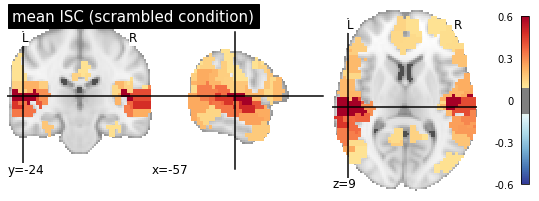

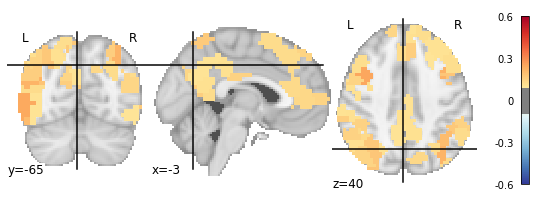

In [190]:
# Project parcel-wise ISC values onto brain
scram_img = np.zeros(atlas.shape)
for i, parcel in enumerate(np.unique(atlas)[1:]):
    scram_img[atlas == parcel] = scram_iscs[i]

# Convert to a NIfTI image for visualization with Nilearn
scram_nii = nib.Nifti1Image(scram_img, atlas_nii.affine, atlas_nii.header)

# Plot scrambled ISCs to visualize superior temporal cortex
plot_stat_map(scram_nii, cmap='RdYlBu_r', vmax=.6, threshold=.1,
              title='mean ISC (scrambled condition)',
              cut_coords=(-57, -24, 9))

# Plot scrambled ISCs to visualize posterior medial cortex
plot_stat_map(scram_nii, cmap='RdYlBu_r', vmax=.6, threshold=.1,
              cut_coords=(-3, -65, 40));

## Intersubject network estimation
Intersubject functional correlation (ISFC) analysis

In [145]:
# Compute ISFC on intact data
intact_isfcs = isfc(intact_parcels, pairwise=False,
                    vectorize_isfcs=False,
                    summary_statistic='mean')

# Compute ISFC on scrambled data
scram_isfcs = isfc(scram_parcels, pairwise=False,
                   vectorize_isfcs=False,
                   summary_statistic='mean')

In [167]:
# Compute mean with Fisher z-transformation
def fisher_mean(correlation, axis=None):
    return np.tanh(np.mean(np.arctanh(correlation), axis=axis))

# Compute within-subject functional connectivity for intact data
intact_fcs = fisher_mean([np.corrcoef(s) for s in intact_parcels.T],
                         axis=0)

# Compute within-subje
scram_fcs = fisher_mean([np.corrcoef(s) for s in scram_parcels.T],
                        axis=0)

In [176]:
from scipy.stats import pearsonr
from scipy.spatial.distance import squareform

In [191]:
# High correlation between intact and scrambled
# for within-subject functional connectivity
pearsonr(squareform(intact_fcs, checks=False),
         squareform(scram_fcs, checks=False))

(0.9504281337619181, 0.0)

In [192]:
# ISFC is more distinct for intact and scrambed conditions
pearsonr(squareform(intact_isfcs, checks=False),
         squareform(scram_isfcs, checks=False))

(0.6316633039419202, 0.0)

#### References
* Chen, G., Shin, Y. W., Taylor, P. A., Glen, D. R., Reynolds, R. C., Israel, R. B., & Cox, R. W. (2016). Untangling the relatedness among correlations, part I: nonparametric approaches to inter-subject correlation analysis at the group level. *NeuroImage*, *142*, 248-259. https://doi.org/10.1016/j.neuroimage.2016.05.023

* Chen, G., Taylor, P. A., Shin, Y. W., Reynolds, R. C., & Cox, R. W. (2017). Untangling the relatedness among correlations, part II: inter-subject correlation group analysis through linear mixed-effects modeling. *NeuroImage*, *147*, 825-840. https://doi.org/10.1016/j.neuroimage.2016.08.029

* Chen, G., Taylor, P. A., Qu, X., Molfese, P. J., Bandettini, P. A., Cox, R. W., & Finn, E. S. (2020). Untangling the relatedness among correlations, part III: inter-subject correlation analysis through Bayesian multilevel modeling for naturalistic scanning. *NeuroImage*, *216*, 116474. https://doi.org/10.1016/j.neuroimage.2019.116474

* Chien, H. Y. S., & Honey, C. J. (2020). Constructing and forgetting temporal context in the human cerebral cortex. *Neuron*, *106*(4), 675-686. https://doi.org/10.1016/j.neuron.2020.02.013

* Hasson, U., Nir, Y., Levy, I., Fuhrmann, G., & Malach, R. (2004). Intersubject synchronization of cortical activity during natural vision. *Science*, *303*(5664), 1634–1640. https://doi.org/10.1126/science.1089506

* Nastase, S. A., Gazzola, V., Hasson, U., & Keysers, C. (2019). Measuring shared responses across subjects using intersubject correlation. *Social Cognitive and Affective Neuroscience*, *14*(6), 667–685. https://doi.org/10.1093/scan/nsz037

* Nastase, S. A., Liu, Y.-F., Hillman, H., Zadbood, A., Hasenfratz, L., Keshavarzian, N., Chen, J., Honey, C. J., Yeshurun, Y., Regev, M., Nguyen, M., Chang, C. H. C., Baldassano, C., Lositsky, O., Simony, E., Chow, M. A., Leong, Y. C., Brooks, P. P., Micciche, E., Choe, G., Goldstein, A., Halchenko, Y. O., Norman, K. A., & Hasson, U. (2019). Narratives: fMRI data for evaluating models of naturalistic language comprehension. *OpenNeuro*, ds002345. https://doi.org/10.18112/openneuro.ds002345.v1.1.2

* Schaefer, A., Kong, R., Gordon, E. M., Laumann, T. O., Zuo, X. N., Holmes, A. J., Eickhoff, S. B., & Yeo, B. T. T. (2018). Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity MRI. *Cerebral Cortex*, *28*(9), 3095-3114. https://doi.org/10.1093/cercor/bhx179